Originally from https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl

In [224]:
import numpy as np
np.random.seed(656)
import os
import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from subprocess import check_output
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D, merge, BatchNormalization, Permute
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [33]:
#Load data
train = pd.read_json("/home/odenigborig/Data/kaggle/statoli_iceberg/data/processed/train.json")
test = pd.read_json("/home/odenigborig/Data/kaggle/statoli_iceberg/data/processed/test.json")

In [34]:
#replace na with zeros in inc_angle (incline) columne
train.inc_angle = train.inc_angle.replace('na', 0) 
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

test.inc_angle = test.inc_angle.replace('na', 0) 
test.inc_angle = test.inc_angle.astype(float).fillna(0.0)

In [35]:
#Prepare training data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis],
                          x_band2[:, :, :, np.newaxis],
                          ((x_band1 + x_band2)/2)[:,:,:, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

#Prepare test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis],
                          x_band2[:, :, :, np.newaxis],
                          ((x_band1 + x_band2)/2)[:,:,:, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)

In [110]:
X_train.shape

(1203, 75, 75, 3)

In [36]:
# Prepare validation set
X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train, 
            X_angle_train,y_train, random_state=123, train_size=0.75)

In [228]:
#functions

def get_callbacks(filepath, patience=2):
    #callback to save model after each epoch
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def get_model():
    bn_model = 0
    p_activation = "elu"
    
    input_1_o = Input(shape=(75,75,3), name="input_X_1")
    input_2_o = Input(shape=[1], name="input_angle")
    
    input_1 = Permute([3,1,2])(input_1_o)
    input_1 = BatchNormalization(momentum=bn_model)(input_1)
    input_2 = BatchNormalization(momentum=bn_model)(input_2_o)
    
    img_1 = Conv2D(16, 3, 3, activation=p_activation, name='conv_1_1')(input_1)
    img_1 = Conv2D(16, 3, 3, activation=p_activation, name='conv_1_2')(input_1)
    img_1 = MaxPooling2D((2,2), name='max_pool_1')(img_1)
    img_1 = Dropout(0.2, name='dropout_1')(img_1)

    img_1 = Conv2D(32, 3, 3, activation=p_activation, name='conv_2_1')(img_1)
    img_1 = Conv2D(32, 3, 3, activation=p_activation, name='conv_2_2')(img_1)
    img_1 = MaxPooling2D((2,2), name='max_pool_2')(img_1)
    img_1 = Dropout(0.2, name='dropout_2')(img_1)
    
    img_1 = Conv2D(64, 3, 3, activation=p_activation, name='conv_3_1')(img_1)
    img_1 = Conv2D(64, 3, 3, activation=p_activation, name='conv_3_2')(img_1)
    img_1 = MaxPooling2D((2,2), name='max_pool_3')(img_1)
    img_1 = Dropout(0.2, name='dropout_3')(img_1)
    
    img_1 = Conv2D(128, 3, 3, activation=p_activation, name='conv_4_1')(img_1)
    img_1 = MaxPooling2D((2,2), name='max_pool_4')(img_1)
    img_1 = Dropout(0.2, name='dropout_4')(img_1)
    img_1 = GlobalMaxPooling2D()(img_1)
    
    img_2 = Conv2D(128, 3, 3, activation=p_activation)(input_1)
    img_2 = MaxPooling2D((2,2))(img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D()(img_2)
    
    #use lower case merge for concatenation of TensorVariables, uppercase Merge is for layers
    img_concat = merge([img_1, img_2,input_2], mode='concat',concat_axis=1)
    
    dense_input = BatchNormalization(momentum=bn_model)(Dense(256, activation=p_activation)(img_concat))
    dense_layer = Dropout(0.5)(dense_input)
    dense_layer = BatchNormalization(momentum=bn_model)(Dense(64, activation=p_activation)(dense_layer))
    dense_layer = Dropout(0.5)(dense_layer)
    output = Dense(1, activation="sigmoid")(dense_layer)
    
    model = Model([input_1_o, input_2_o], output)
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model



In [232]:
model = get_model()
model.summary()

In [226]:
path = os.getcwd()
model_path=path + 'models/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [233]:
file_path = model_path + ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model.fit([X_train, X_angle_train], y_train, nb_epoch=25, 
          validation_data=([X_valid, X_angle_valid], y_valid), 
          batch_size=64, callbacks = callbacks)

Train on 1203 samples, validate on 401 samples
Epoch 1/25
1203/1203 [==============================] - 2s - loss: 0.8072 - acc: 0.6342 - val_loss: 0.6604 - val_acc: 0.7157
Epoch 2/25
1203/1203 [==============================] - 2s - loss: 0.7032 - acc: 0.6783 - val_loss: 0.5975 - val_acc: 0.7332
Epoch 3/25
1203/1203 [==============================] - 2s - loss: 0.6868 - acc: 0.6733 - val_loss: 0.5628 - val_acc: 0.7282
Epoch 4/25
1203/1203 [==============================] - 2s - loss: 0.6347 - acc: 0.7016 - val_loss: 0.7041 - val_acc: 0.7232
Epoch 5/25
1203/1203 [==============================] - 2s - loss: 0.6419 - acc: 0.7265 - val_loss: 0.5949 - val_acc: 0.7382
Epoch 6/25
1203/1203 [==============================] - 2s - loss: 0.6029 - acc: 0.7249 - val_loss: 0.5318 - val_acc: 0.7431
Epoch 7/25
1203/1203 [==============================] - 2s - loss: 0.6140 - acc: 0.7165 - val_loss: 0.8108 - val_acc: 0.6908
Epoch 8/25
1203/1203 [==============================] - 2s - loss: 0.5419 - ac

In [235]:
model.load_weights(filepath=file_path)

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], 
                     y_train, verbose=1, batch_size=200))
print("###########################")
print("Valid evaluate:")
print(model.evaluate([X_valid, X_angle_valid], 
                     y_valid, verbose=1, batch_size=200))

Train evaluate:
1200/1203 [============================>.] - ETA: 0s[0.45663800468964072, 0.78802993831690016]
###########################
Valid evaluate:
400/401 [============================>.] - ETA: 0s[0.48111852572445857, 0.78553615603363725]


In [236]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [187]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.004060
1,4023181e,0.025510
2,b20200e4,0.000046
3,e7f018bb,0.987340
4,4371c8c3,0.101262
5,a8d9b1fd,0.546288
6,29e7727e,0.003137
7,92a51ffb,0.999269
8,c769ac97,0.030284
9,aee0547d,0.007589


In [237]:
submission.to_csv("submission1.csv", index=False)

In [238]:
#create downloadable submission file to upload
submission_filename = 'submission1.csv'

from IPython.display import FileLink
FileLink(submission_filename)

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission1.csv

### Now let's try some things we learned from the course:
- data augmentation
- regularize

In [144]:
from keras.preprocessing import image
from scipy import ndimage
from matplotlib import pyplot as plt
%matplotlib inline

In [163]:
#specify data augmentation types
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                               height_shift_range=0.1, shear_range=0.1,
                               zoom_range=0.1, channel_shift_range=10.,
                               horizontal_flip=True, dim_ordering='tf')

(-0.5, 74.5, 74.5, -0.5)

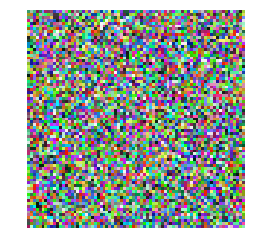

In [181]:
img = X_train[110,:,:,:]
plt.imshow(img)
plt.axis('off')

In [191]:
batch_size = 64
#request the generator to create batches from dataset
aug_iter = gen.flow(X_train,batch_size=batch_size, shuffle=True)


In [184]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


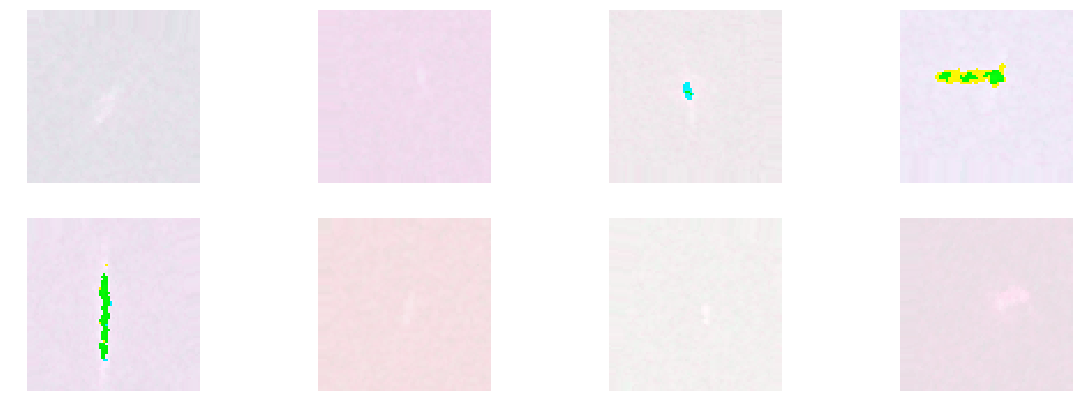

In [185]:
#display augmented images, up to 8
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
plots(aug_imgs,(20,7),2)

(75, 75, 3)


(-0.5, 74.5, 74.5, -0.5)

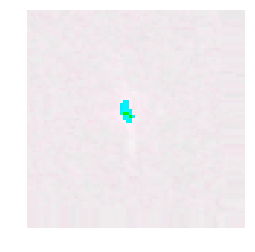

In [186]:
print(aug_imgs[2].shape)
plt.imshow(aug_imgs[2])
plt.axis('off')

Because we have the additional feature of angles, which is not an image we need to include that in the generator. 
One way to do this is to create two generators, and set the y input argument to true labels or the angle

In [193]:
def gen_flow_two_inputs(img_data, angle_data, y_label):
    gen1 = gen.flow(X=img_data,y=y_label, batch_size=batch_size, seed=350)
    gen2 = gen.flow(X=img_data,y=angle_data, batch_size=batch_size, seed=350)
    
    while True:
        X1 = gen1.next()
        X2 = gen2.next()
        
        #return batches
        yield [X1[0], X2[1]], X1[1]

#create generator
gen_flow = gen_flow_two_inputs(X_train, X_angle_train, y_train)

In [207]:
gen1 = gen.flow(X=X_train,y=y_train, batch_size=batch_size, seed=350)
gen2 = gen.flow(X=X_train,y=X_angle_train, batch_size=batch_size, seed=350)
X1 = gen1.next()
X2 = gen2.next()

print(X1[0].shape) 
print(X1[1].shape)
print(X2[1].shape)

(64, 75, 75, 3)
(64,)
(64,)


In [239]:
#re-intialize model
#model = get_model() 
batch_size = 64
#fit model with generator batches
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
64/64 [==============================] - 0s - loss: 0.6306 - acc: 0.6719 - val_loss: 0.5908 - val_acc: 0.7307
Epoch 2/25
64/64 [==============================] - 0s - loss: 0.7080 - acc: 0.6250 - val_loss: 0.5135 - val_acc: 0.7531
Epoch 3/25
64/64 [==============================] - 0s - loss: 0.5445 - acc: 0.7500 - val_loss: 0.4742 - val_acc: 0.7681
Epoch 4/25
64/64 [==============================] - 0s - loss: 0.5815 - acc: 0.7188 - val_loss: 0.5363 - val_acc: 0.7556
Epoch 5/25
64/64 [==============================] - 0s - loss: 0.6463 - acc: 0.6875 - val_loss: 0.4907 - val_acc: 0.7706
Epoch 6/25
64/64 [==============================] - 0s - loss: 0.6805 - acc: 0.7031 - val_loss: 0.5317 - val_acc: 0.7506
Epoch 7/25
64/64 [==============================] - 0s - loss: 0.7160 - acc: 0.7188 - val_loss: 0.5925 - val_acc: 0.7232
Epoch 8/25
64/64 [==============================] - 0s - loss: 0.6132 - acc: 0.6875 - val_loss: 0.5998 - val_acc: 0.7207
Epoch 9/25
115/64 [=============

In [240]:

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("###########################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
1200/1203 [============================>.] - ETA: 0s[0.59537524747927784, 0.72319201563956437]
###########################
watch list evaluate:
400/401 [============================>.] - ETA: 0s[0.59710762219647517, 0.73316706921394326]


In [241]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [242]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.739975
1,4023181e,0.344589
2,b20200e4,0.004078
3,e7f018bb,0.799160
4,4371c8c3,0.670332
5,a8d9b1fd,0.317822
6,29e7727e,0.882011
7,92a51ffb,0.955356
8,c769ac97,0.868325
9,aee0547d,0.172535


In [243]:
submission.to_csv("submission2.csv", index=False)

In [244]:
#create downloadable submission file to upload
submission_filename = 'submission2.csv'

from IPython.display import FileLink
FileLink(submission_filename)

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission2.csv

In [245]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.fit_generator(gen_flow,samples_per_epoch = batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=15, callbacks = callbacks)


Epoch 1/15
64/64 [==============================] - 0s - loss: 0.4727 - acc: 0.7188 - val_loss: 0.5221 - val_acc: 0.7556
Epoch 2/15
64/64 [==============================] - 0s - loss: 0.5401 - acc: 0.7500 - val_loss: 0.5793 - val_acc: 0.7382
Epoch 3/15
64/64 [==============================] - 0s - loss: 0.6779 - acc: 0.6562 - val_loss: 0.4377 - val_acc: 0.8055
Epoch 4/15
64/64 [==============================] - 0s - loss: 0.6110 - acc: 0.7188 - val_loss: 0.5735 - val_acc: 0.7481
Epoch 5/15
64/64 [==============================] - 0s - loss: 0.6067 - acc: 0.7500 - val_loss: 0.7168 - val_acc: 0.7032
Epoch 6/15
64/64 [==============================] - 0s - loss: 0.6901 - acc: 0.6562 - val_loss: 0.5600 - val_acc: 0.7656
Epoch 7/15
64/64 [==============================] - 0s - loss: 0.7958 - acc: 0.7188 - val_loss: 0.5856 - val_acc: 0.7731
Epoch 8/15
64/64 [==============================] - 0s - loss: 0.5143 - acc: 0.8281 - val_loss: 0.6159 - val_acc: 0.7481
Epoch 9/15
64/64 [==============

In [246]:

print("Train evaluate:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("###########################")
print("watch list evaluate:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Train evaluate:
1200/1203 [============================>.] - ETA: 0s[0.51909146461007205, 0.76226101219901821]
###########################
watch list evaluate:
400/401 [============================>.] - ETA: 0s[0.53613831732710104, 0.76558602064327708]


In [247]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8400/8424 [============================>.] - ETA: 0s

In [248]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.head(10)

,id,is_iceberg
0,5941774d,0.726690
1,4023181e,0.330245
2,b20200e4,0.001824
3,e7f018bb,0.720863
4,4371c8c3,0.610664
5,a8d9b1fd,0.290876
6,29e7727e,0.889366
7,92a51ffb,0.943029
8,c769ac97,0.783905
9,aee0547d,0.125785


In [249]:
submission.to_csv("submission3.csv", index=False)

In [250]:
#create downloadable submission file to upload
submission_filename = 'submission3.csv'

from IPython.display import FileLink
FileLink(submission_filename)

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission3.csv

In [252]:
optimizer = Adam(lr=1e-5)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=15, callbacks = callbacks)


Epoch 1/15
64/64 [==============================] - 0s - loss: 0.6096 - acc: 0.7344 - val_loss: 0.4705 - val_acc: 0.7606
Epoch 2/15
64/64 [==============================] - 0s - loss: 0.4990 - acc: 0.7656 - val_loss: 0.4963 - val_acc: 0.7731
Epoch 3/15
64/64 [==============================] - 0s - loss: 0.5694 - acc: 0.7031 - val_loss: 0.4724 - val_acc: 0.7805
Epoch 4/15
64/64 [==============================] - 0s - loss: 0.5828 - acc: 0.6875 - val_loss: 0.4904 - val_acc: 0.7531
Epoch 5/15
64/64 [==============================] - 0s - loss: 0.5090 - acc: 0.7344 - val_loss: 0.4555 - val_acc: 0.7855
Epoch 6/15
64/64 [==============================] - 0s - loss: 0.6962 - acc: 0.7188 - val_loss: 0.4571 - val_acc: 0.7681
Epoch 7/15
64/64 [==============================] - 0s - loss: 0.6748 - acc: 0.6875 - val_loss: 0.4779 - val_acc: 0.7706
Epoch 8/15
64/64 [==============================] - 0s - loss: 0.8203 - acc: 0.5938 - val_loss: 0.4647 - val_acc: 0.7731
Epoch 9/15
64/64 [==============

In [253]:
#compute predictions
model.save_weights(model_path+'model_4.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission4.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission4.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8400/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission4.csv

In [256]:
#let's go crazy with the augmentation types

#specify data augmentation types
gen = image.ImageDataGenerator(rotation_range=40, width_shift_range=0.5,
                               height_shift_range=0.3, shear_range=0.1,
                               rescale=1./255,
                               zoom_range=0.2, channel_shift_range=10.,
                               horizontal_flip=True, dim_ordering='tf')

In [259]:
optimizer = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

batch_size = 128
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
128/128 [==============================] - 0s - loss: 0.6651 - acc: 0.6797 - val_loss: 0.4408 - val_acc: 0.7955
Epoch 2/25
128/128 [==============================] - 0s - loss: 0.5886 - acc: 0.7500 - val_loss: 0.4618 - val_acc: 0.7830
Epoch 3/25
128/128 [==============================] - 0s - loss: 0.6947 - acc: 0.6797 - val_loss: 0.4706 - val_acc: 0.7805
Epoch 4/25
128/128 [==============================] - 0s - loss: 0.6581 - acc: 0.6797 - val_loss: 0.4325 - val_acc: 0.8030
Epoch 5/25
179/128 [=========================================] - 0s - loss: 0.7524 - acc: 0.6425 - val_loss: 0.4270 - val_acc: 0.8080
Epoch 6/25
128/128 [==============================] - 0s - loss: 0.5903 - acc: 0.7734 - val_loss: 0.4845 - val_acc: 0.7756
Epoch 7/25
128/128 [==============================] - 0s - loss: 0.5808 - acc: 0.7266 - val_loss: 0.4376 - val_acc: 0.8155
Epoch 8/25
128/128 [==============================] - 0s - loss: 0.7503 - acc: 0.6406 - val_loss: 0.4491 - val_acc: 0.7980
Epoch

In [260]:
model.save_weights(model_path+'model_5.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission5.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission5.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8400/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission5.csv

In [261]:
#re-initialize model
model = get_model()

#specify data augmentation types
gen = image.ImageDataGenerator(rotation_range=40, width_shift_range=0.1,
                               height_shift_range=0.1,zoom_range=0.1, 
                               vertical_flip = True,horizontal_flip=True)

In [268]:
optimizer = Adam(lr=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

batch_size = 64
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
64/64 [==============================] - 0s - loss: 0.6501 - acc: 0.6406 - val_loss: 0.5328 - val_acc: 0.7581
Epoch 2/25
64/64 [==============================] - 0s - loss: 0.7338 - acc: 0.7031 - val_loss: 0.5345 - val_acc: 0.7880
Epoch 3/25
64/64 [==============================] - 0s - loss: 0.8939 - acc: 0.6250 - val_loss: 0.5213 - val_acc: 0.7880
Epoch 4/25
64/64 [==============================] - 0s - loss: 0.8886 - acc: 0.6250 - val_loss: 0.5419 - val_acc: 0.7631
Epoch 5/25
64/64 [==============================] - 0s - loss: 0.6031 - acc: 0.7031 - val_loss: 0.6321 - val_acc: 0.7431
Epoch 6/25
64/64 [==============================] - 0s - loss: 0.8113 - acc: 0.5781 - val_loss: 0.5300 - val_acc: 0.7706
Epoch 7/25
64/64 [==============================] - 0s - loss: 0.7825 - acc: 0.6094 - val_loss: 0.5705 - val_acc: 0.7656
Epoch 8/25
64/64 [==============================] - 0s - loss: 0.7068 - acc: 0.6562 - val_loss: 0.5349 - val_acc: 0.7880
Epoch 9/25
64/64 [==============

In [267]:
model.save_weights(model_path+'model_6.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission6.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission6.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8416/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission6.csv

In [269]:
optimizer = Adam(lr=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

batch_size = 64
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
64/64 [==============================] - 0s - loss: 0.6585 - acc: 0.6719 - val_loss: 0.5185 - val_acc: 0.7980
Epoch 2/25
64/64 [==============================] - 0s - loss: 0.6716 - acc: 0.7031 - val_loss: 0.5518 - val_acc: 0.7880
Epoch 3/25
64/64 [==============================] - 0s - loss: 0.6625 - acc: 0.6875 - val_loss: 0.5590 - val_acc: 0.7781
Epoch 4/25
64/64 [==============================] - 0s - loss: 0.6033 - acc: 0.7500 - val_loss: 0.5050 - val_acc: 0.8105
Epoch 5/25
64/64 [==============================] - 0s - loss: 0.7475 - acc: 0.6406 - val_loss: 0.5543 - val_acc: 0.7830
Epoch 6/25
64/64 [==============================] - 0s - loss: 0.5030 - acc: 0.8281 - val_loss: 0.5905 - val_acc: 0.7606
Epoch 7/25
64/64 [==============================] - 0s - loss: 0.6240 - acc: 0.7188 - val_loss: 0.5165 - val_acc: 0.8055
Epoch 8/25
115/64 [=====================================================] - 0s - loss: 0.8117 - acc: 0.6000 - val_loss: 0.5950 - val_acc: 0.7481
Epoch 9/

In [270]:
model.save_weights(model_path+'model_7.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission7.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission7.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8416/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission7.csv

In [274]:
optimizer = Adam(lr=1e-5)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

batch_size = 64
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
64/64 [==============================] - 0s - loss: 0.8144 - acc: 0.6875 - val_loss: 0.4874 - val_acc: 0.8105
Epoch 2/25
64/64 [==============================] - 0s - loss: 0.6679 - acc: 0.7031 - val_loss: 0.5436 - val_acc: 0.7781
Epoch 3/25
64/64 [==============================] - 0s - loss: 0.4569 - acc: 0.7969 - val_loss: 0.5054 - val_acc: 0.7830
Epoch 4/25
64/64 [==============================] - 0s - loss: 0.5099 - acc: 0.7812 - val_loss: 0.5199 - val_acc: 0.7855
Epoch 5/25
64/64 [==============================] - 0s - loss: 0.6979 - acc: 0.7344 - val_loss: 0.4923 - val_acc: 0.8130
Epoch 6/25
64/64 [==============================] - 0s - loss: 0.7474 - acc: 0.6094 - val_loss: 0.5778 - val_acc: 0.7681
Epoch 7/25
64/64 [==============================] - 0s - loss: 0.6783 - acc: 0.6719 - val_loss: 0.4756 - val_acc: 0.8229
Epoch 8/25
64/64 [==============================] - 0s - loss: 0.6977 - acc: 0.7344 - val_loss: 0.6498 - val_acc: 0.7257
Epoch 9/25
64/64 [==============

In [275]:
model.save_weights(model_path+'model_8.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission8.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission8.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8416/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission8.csv

In [278]:
optimizer = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

batch_size = 64
model.fit_generator(gen_flow,samples_per_epoch= batch_size,
                    validation_data=([X_valid, X_angle_valid], y_valid),
                    nb_epoch=25, callbacks = callbacks)


Epoch 1/25
64/64 [==============================] - 0s - loss: 0.5679 - acc: 0.7812 - val_loss: 0.5938 - val_acc: 0.7357
Epoch 2/25
64/64 [==============================] - 0s - loss: 0.5823 - acc: 0.7344 - val_loss: 0.5230 - val_acc: 0.7706
Epoch 3/25
64/64 [==============================] - 0s - loss: 0.4501 - acc: 0.7188 - val_loss: 0.5800 - val_acc: 0.7257
Epoch 4/25
64/64 [==============================] - 0s - loss: 0.5811 - acc: 0.6406 - val_loss: 0.4919 - val_acc: 0.7905
Epoch 5/25
64/64 [==============================] - 0s - loss: 0.7736 - acc: 0.6875 - val_loss: 0.4554 - val_acc: 0.8130
Epoch 6/25
64/64 [==============================] - 0s - loss: 0.5201 - acc: 0.7812 - val_loss: 0.5106 - val_acc: 0.7756
Epoch 7/25
64/64 [==============================] - 0s - loss: 0.4955 - acc: 0.7656 - val_loss: 0.4650 - val_acc: 0.8180
Epoch 8/25
64/64 [==============================] - 0s - loss: 0.7652 - acc: 0.6406 - val_loss: 0.5327 - val_acc: 0.7681
Epoch 9/25
64/64 [==============

In [279]:
model.save_weights(model_path+'model_9.h5')
prediction = model.predict([X_test, X_angle_test], verbose=1)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission.to_csv("submission9.csv", index=False)

#create downloadable submission file to upload
submission_filename = 'submission9.csv'

from IPython.display import FileLink
FileLink(submission_filename)

8416/8424 [============================>.] - ETA: 0s

/home/odenigborig/Github/Kaggle/statoli_iceberg/submission9.csv